<a href="https://colab.research.google.com/github/Aridel7/Study_2/blob/TSML/TSML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Элементарные методы анализа временных рядов**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. daily-total-female-births-in-cal

In [2]:
series_1 = pd.read_csv('/content/daily-total-female-births-in-cal.csv')['Count']
series_1.head()

0    35
1    32
2    30
3    31
4    44
Name: Count, dtype: int64

Text(0, 0.5, 'Daily amount of female births')

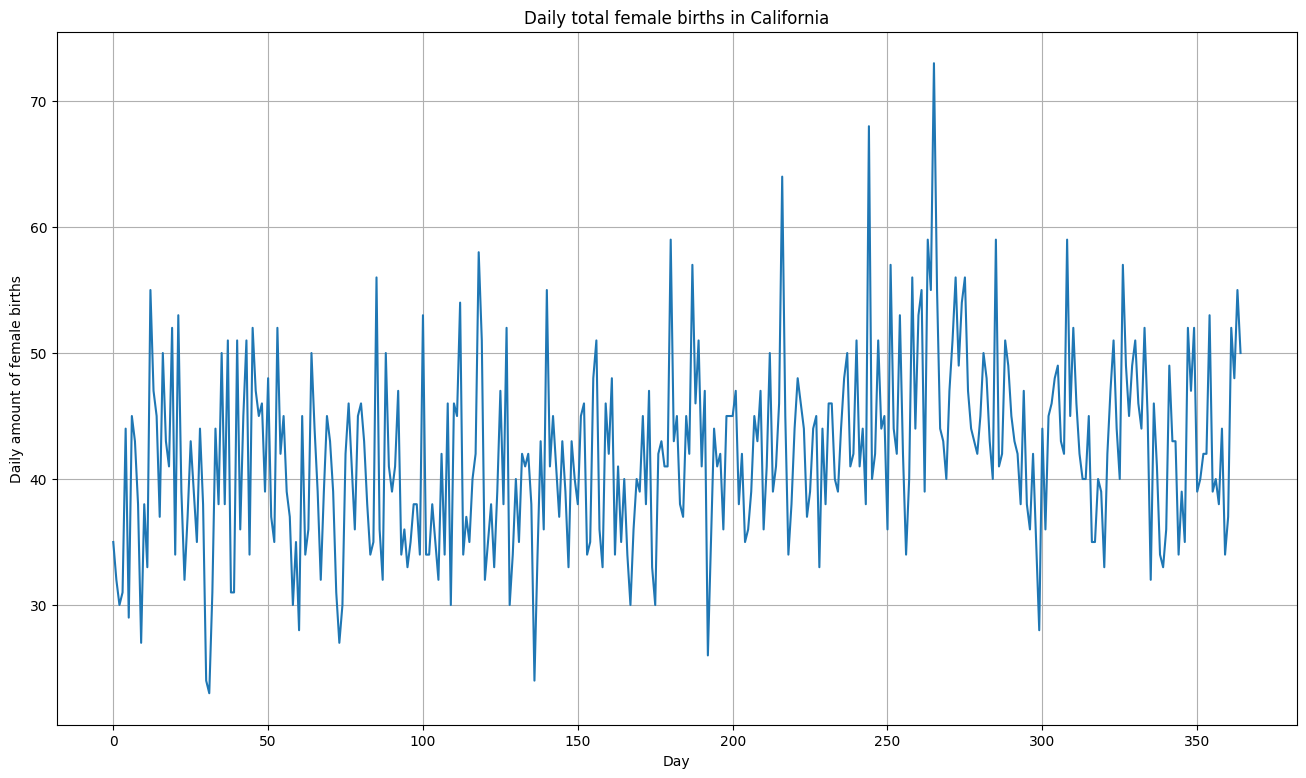

In [8]:
plt.figure(figsize=(16,9))
plt.plot(series_1)
plt.grid()
plt.title('Daily total female births in California')
plt.xlabel('Day')
plt.ylabel('Daily amount of female births')

In [83]:
def centered_moving_average(array, n, method = 'mean'):
  flag = 0
  smoothed_array = array.copy()
  for i in range(int(np.floor(n/2)), int(len(array) - np.floor(n/2))):
    if method == 'median':
      smoothed_array[i] = np.median(array[i - int(np.floor(n/2)) : i + int(np.floor(n/2)) + 1])
    elif method == 'mean':
      smoothed_array[i] = np.mean(array[i - int(np.floor(n/2)) : i + int(np.floor(n/2)) + 1])
    else:
      flag = 1
      smoothed_array[i] = np.mean(array[i - int(np.floor(n/2)) : i + int(np.floor(n/2)) + 1])
  if flag == 1:
    print('Unknown method. Used \'mean\' instead')
  smoothed_array[0:int(np.floor(n/2))] = 0
  smoothed_array[-int(np.floor(n/2)):] = 0
  return smoothed_array

In [93]:
smoothed_array = centered_moving_average(series_1.to_numpy(), 25)
smoothed_array = centered_moving_average(smoothed_array, 15, method = 'median')

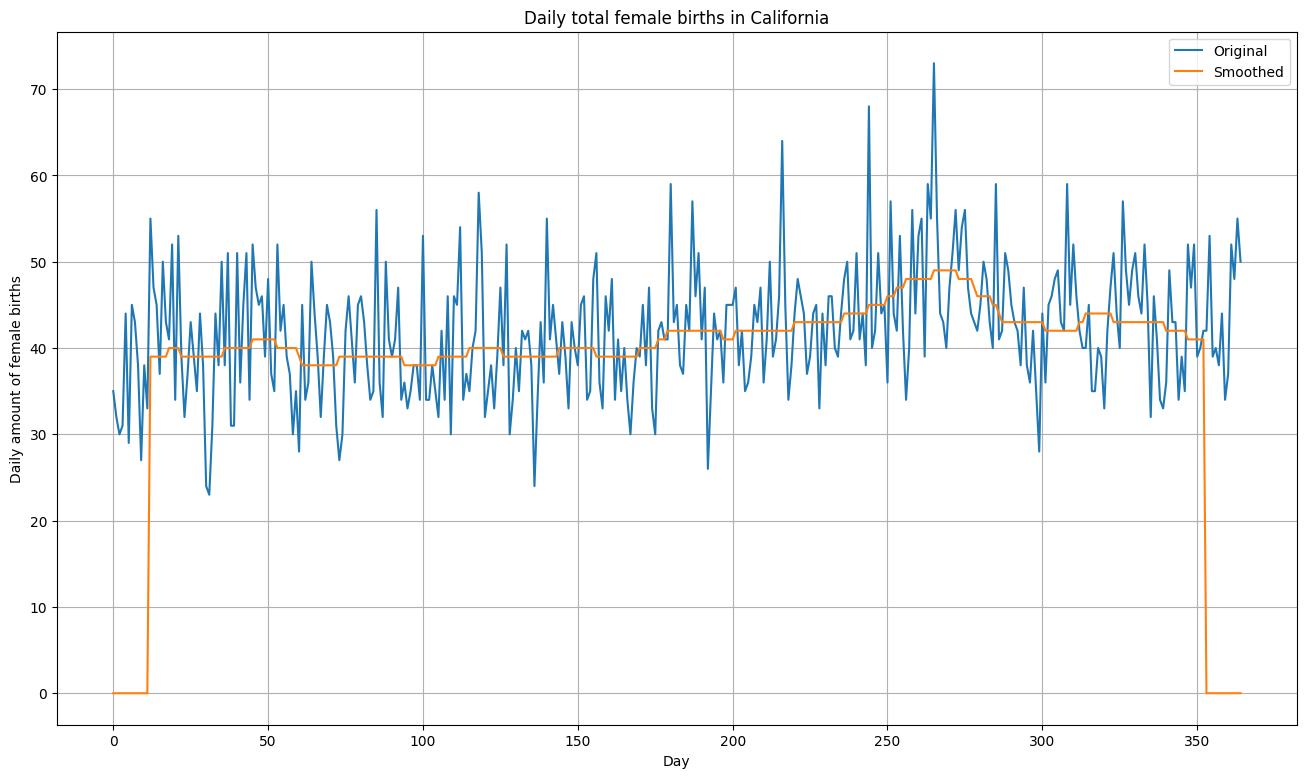

In [97]:
plt.figure(figsize=(16,9))
plt.plot(series_1, label='Original')
plt.plot(smoothed_array, label='Smoothed')
plt.grid()
plt.title('Daily total female births in California')
plt.xlabel('Day')
plt.ylabel('Daily amount of female births')
plt.legend()

Оцените качество и пришлите соображения, почему была выбрана та или иная модель

**Ответ:** Учитывая, что решается описательная задача приближения временного ряда, которая не требует предсказаний будущих значений, а также, что визуально временной ряд является зашумленным (пытаться повторить в модели шум выглядит нелогичным), использована модель скользящего арифметического среднего на первом этапе для снижения шума и модель скользящего медианного на втором этапе для снижения влияния выбросов. Качество полученной модели - среднее (за гладкость линии еще можно побороться).

2. international-airline-passengers

In [95]:
series_2 = pd.read_csv('/content/international-airline-passengers.csv')['Count']
series_2.head()

0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64

Text(0, 0.5, 'Monthy amount of International airline passenger, thousands')

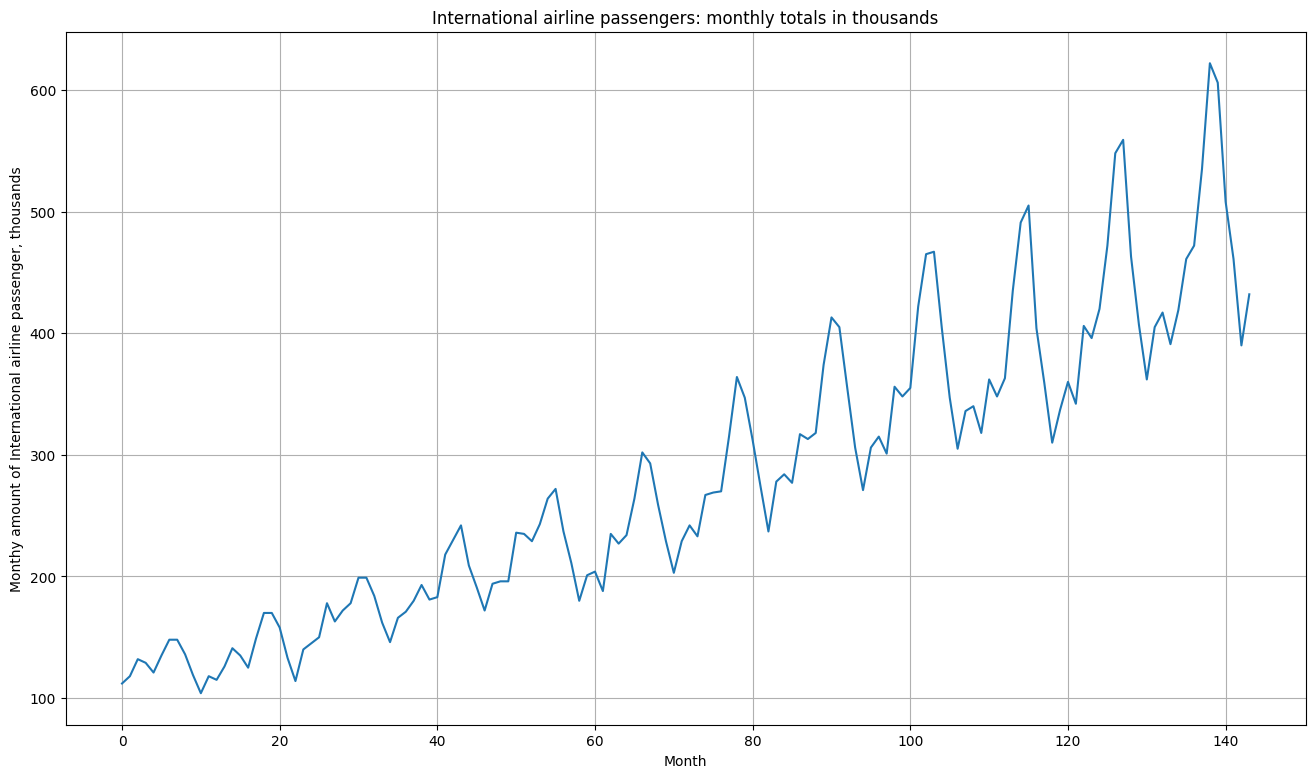

In [99]:
plt.figure(figsize=(16,9))
plt.plot(series_2)
plt.grid()
plt.title('International airline passengers: monthly totals in thousands')
plt.xlabel('Month')
plt.ylabel('Monthy amount of International airline passenger, thousands')

In [109]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [100]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [101]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [102]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [105]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test, squared=False)
    return error

In [119]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={:.5f}, beta={:.5f}, gamma={:.5f}".format(alpha, beta, gamma))
        plt.legend()

In [107]:
train, test = series_2[:110], series_2[110:]

In [110]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [111]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 23.3668862376762
        x: [ 2.930e-02  7.315e-01  7.197e-01]
      nit: 28
      jac: [-3.416e+02 -1.495e+01 -2.139e+01]
     nfev: 184
     njev: 46
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


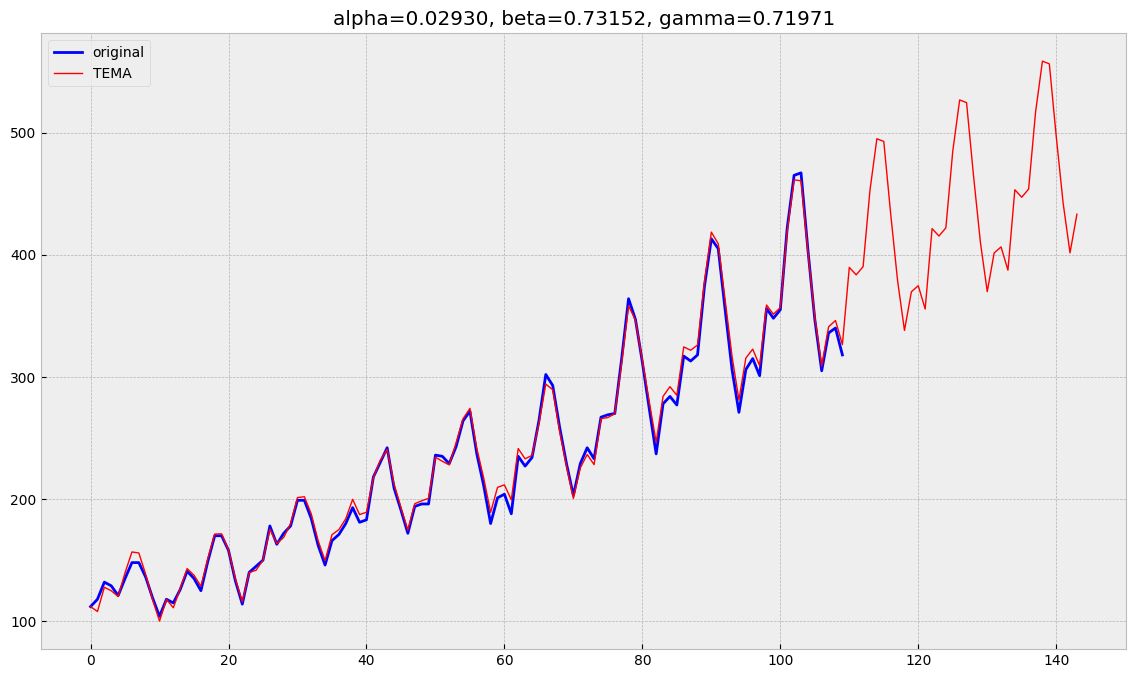

In [120]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=train, n_preds=len(test))

Оцените качество и пришлите соображения, почему была выбрана та или иная модель

**Ответ:** Учитывая, что визуально временной ряд не является зашумленным, а также отчетливо видны тренд и сезонность использована модель Хольт-Винтерса с параметрами, полученными в результате минимизации RMSE. Минимизация использована по причине того, что эмпирические методы подбора параметров проигрывают при задаче максимально подробного повторения заданного временного ряда.